In [28]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

**Define File Path**

In [29]:
image_dir = Path('C:/Users/USER/Desktop/Engineering/Documentation - Machine Learning/Interview Test/Hewlett Packard Enterprise/archive/images')

**Generate DataFrame with ImageFilePath and Label**

In [56]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis = 1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [57]:
image_df

,Filepath,Label
0,C:\Users\USER\Desktop\Engineering\Documentatio...,paella
1,C:\Users\USER\Desktop\Engineering\Documentatio...,steak
2,C:\Users\USER\Desktop\Engineering\Documentatio...,bread_pudding
3,C:\Users\USER\Desktop\Engineering\Documentatio...,waffles
4,C:\Users\USER\Desktop\Engineering\Documentatio...,french_toast
...,...,...
10095,C:\Users\USER\Desktop\Engineering\Documentatio...,croque_madame
10096,C:\Users\USER\Desktop\Engineering\Documentatio...,poutine
10097,C:\Users\USER\Desktop\Engineering\Documentatio...,breakfast_burrito
10098,C:\Users\USER\Desktop\Engineering\Documentatio...,guacamole


**Train test split**

In [58]:
train_df, test_df = train_test_split(image_df, test_size=0.3, random_state=42)

**Create Generators using MobileNetV2**

In [59]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [60]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training')

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation')

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


**Modeling**

In [61]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [62]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

**Training**

In [63]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True)
    ])

Epoch 1/100
177/177 [==============================] - 136s 749ms/step - loss: 3.8555 - accuracy: 0.1361 - val_loss: 3.0488 - val_accuracy: 0.2581
Epoch 2/100
177/177 [==============================] - 135s 763ms/step - loss: 2.4391 - accuracy: 0.3879 - val_loss: 2.4993 - val_accuracy: 0.3692
Epoch 3/100
177/177 [==============================] - 139s 783ms/step - loss: 1.8445 - accuracy: 0.5202 - val_loss: 2.4095 - val_accuracy: 0.3953
Epoch 4/100
177/177 [==============================] - 142s 802ms/step - loss: 1.4804 - accuracy: 0.6025 - val_loss: 2.3458 - val_accuracy: 0.4102
Epoch 5/100
177/177 [==============================] - 146s 827ms/step - loss: 1.1676 - accuracy: 0.6902 - val_loss: 2.3338 - val_accuracy: 0.4314
Epoch 6/100
177/177 [==============================] - 125s 708ms/step - loss: 0.9195 - accuracy: 0.7557 - val_loss: 2.4322 - val_accuracy: 0.4187
Epoch 7/100
177/177 [==============================] - 129s 726ms/step - loss: 0.6824 - accuracy: 0.8204 - val_loss: 2

**Result**

In [73]:
predictions

array([ 9, 81, 32, ..., 97, 81, 28], dtype=int64)

In [64]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 41.49%


In [65]:
predictions = np.argmax(model.predict(test_images), axis = 1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions)

In [74]:
predictions

array([ 9, 81, 32, ..., 97, 81, 28], dtype=int64)

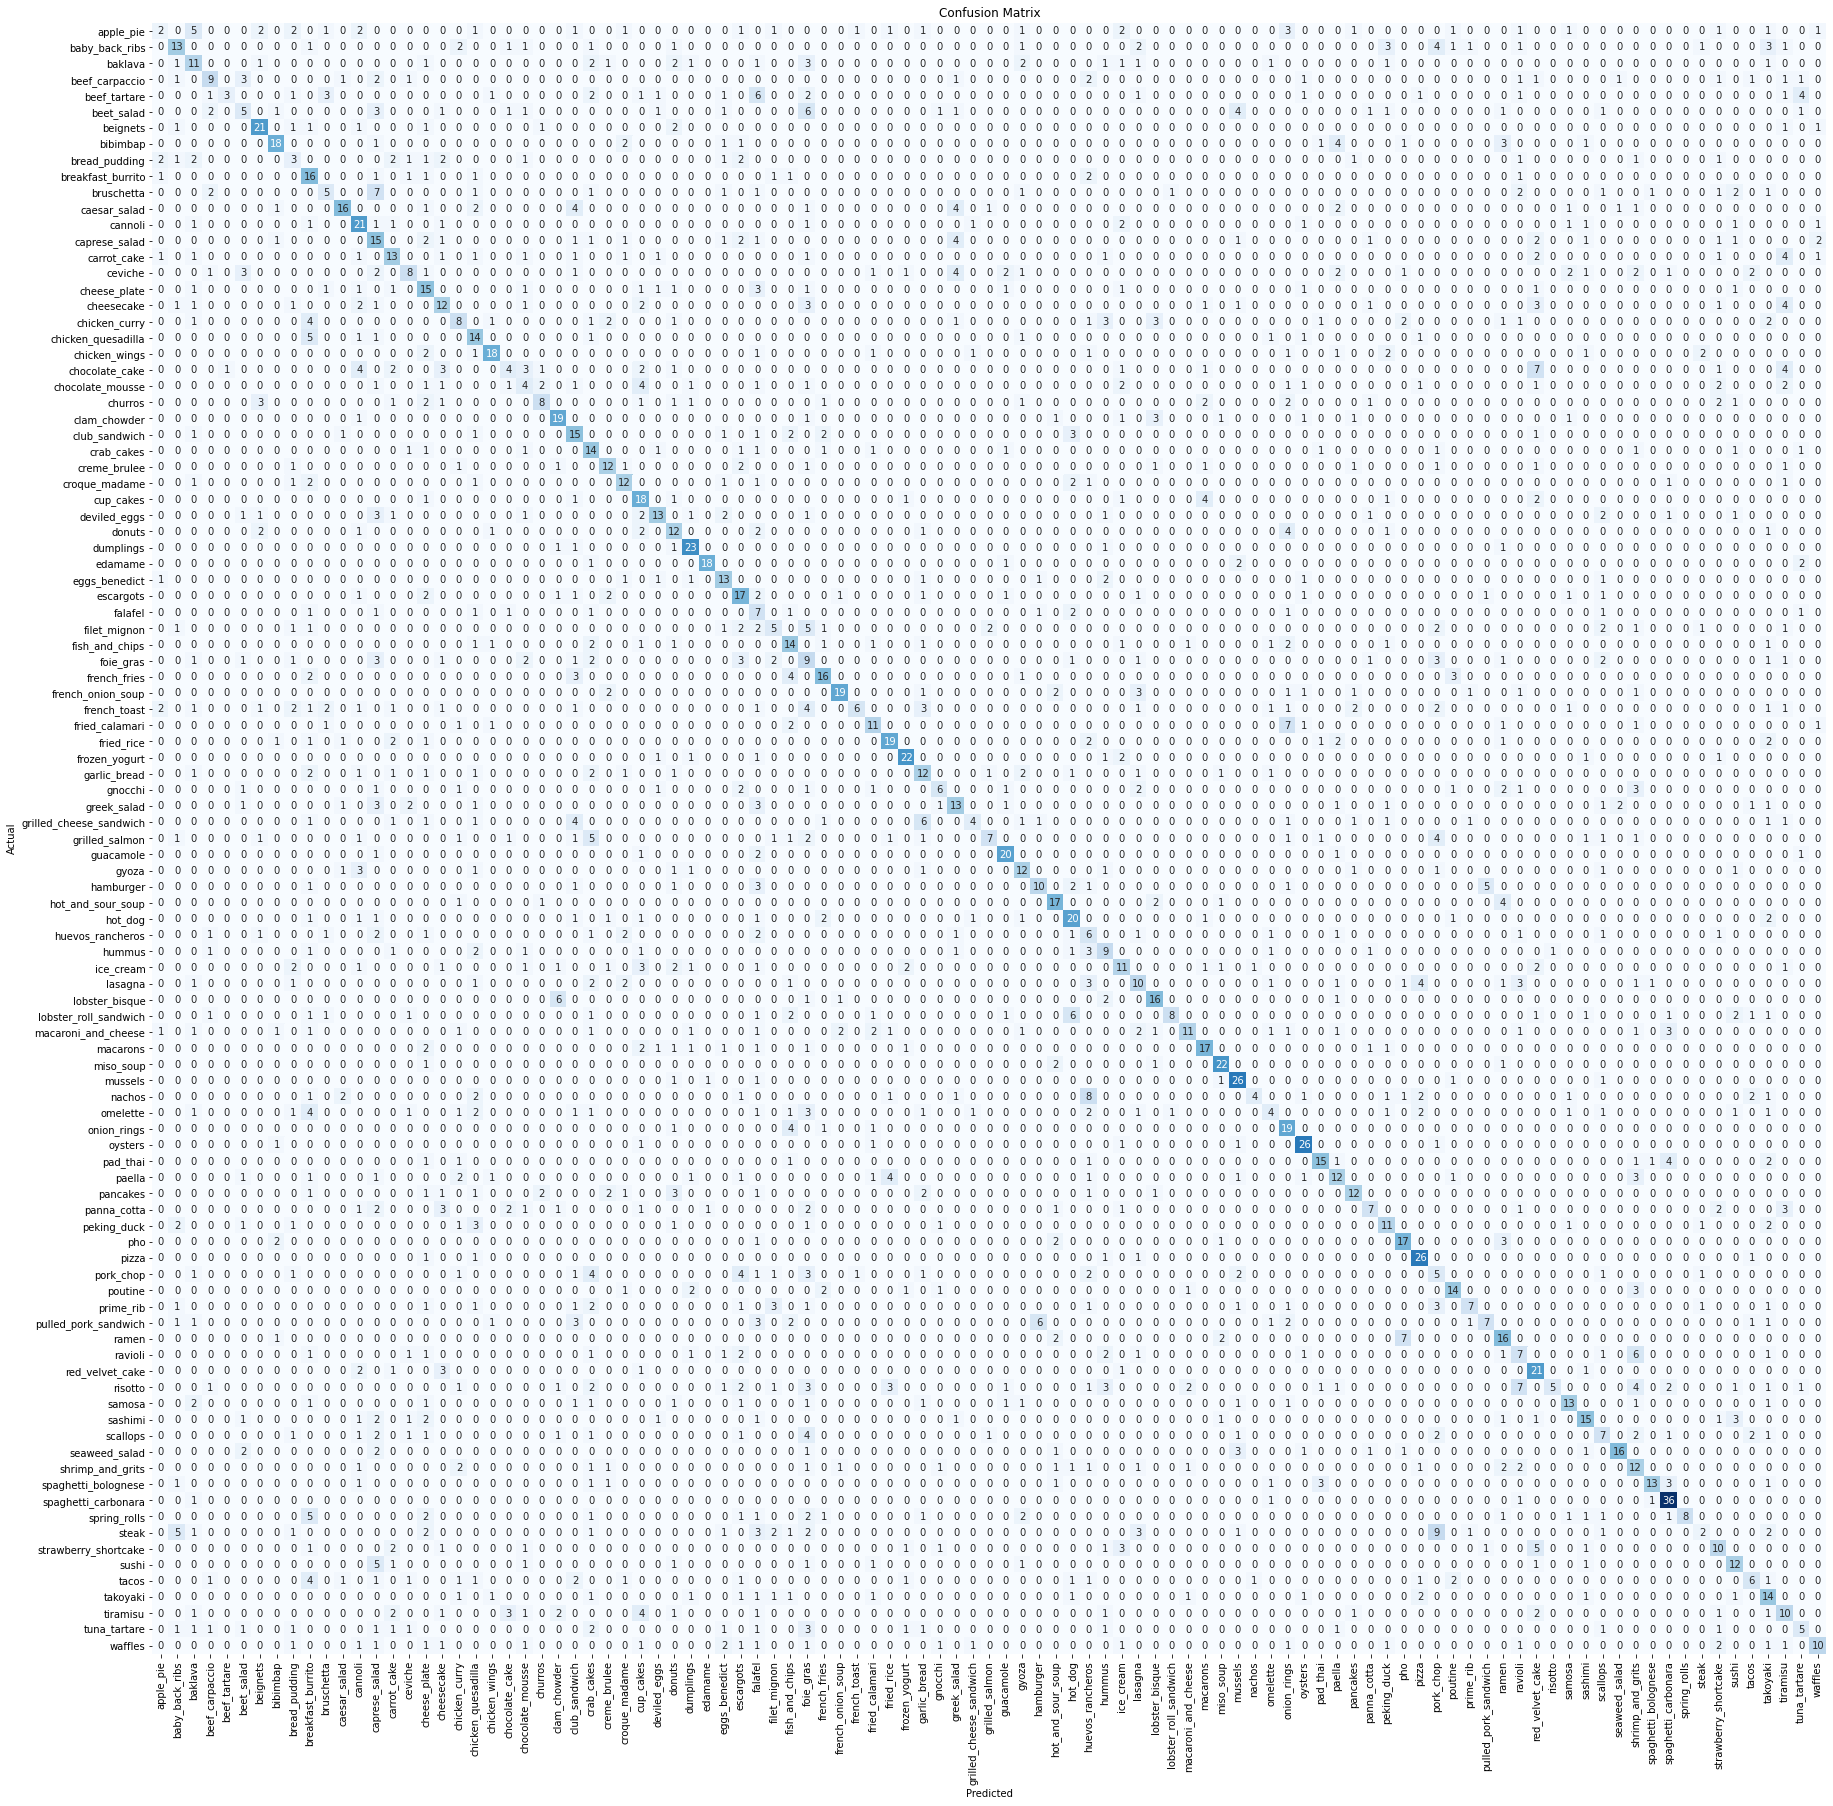

In [66]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [69]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.20      0.06      0.09        35
           1       0.42      0.34      0.38        38
           2       0.28      0.34      0.31        32
           3       0.43      0.32      0.37        28
           4       0.75      0.10      0.17        31
           5       0.24      0.15      0.19        33
           6       0.64      0.68      0.66        31
           7       0.67      0.55      0.60        33
           8       0.12      0.14      0.13        22
           9       0.25      0.62      0.36        26
          10       0.33      0.18      0.23        28
          11       0.67      0.46      0.54        35
          12       0.40      0.60      0.48        35
          13       0.22      0.38      0.28        39
          14       0.38      0.41      0.39        32
          15       0.38      0.22      0.28        36
          16       0.28      0.47 